# 动手学深度学习 章节7.4 含并行连接的网络 (GoogLeNet) 代码实现

In [1]:
import torch
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F

定义inception块

In [2]:
class Inception(nn.Module):
	def __init__(self, in_channels, c1, c2, c3, c4, **kwargs) -> None:
		"""
		Args:
			in_channels: (int) number of input channels
			c1: (int) number of output channels of the path 1
			c2: (tuple) path_2的1X1卷积层output channels, path_2的3X3卷积层output channels
			c3: (tuple) path_3的1X1卷积层output channels, path_3的5X5卷积层output channels
			c4: (int) path_4的1X1卷积层的output channels

		"""
		super().__init__(**kwargs)
		self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
		self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
		self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
		self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
		self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
		self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
		self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)
	
	def forward(self, X):
		p1 = F.relu(self.p1_1(X))
		p2 = F.relu(self.p2_2(F.relu(self.p2_1(X))))
		p3 = F.relu(self.p3_2(F.relu(self.p3_1(X))))
		p4 = F.relu(self.p4_2(self.p4_1(X)))
	
		# 将所有的path在通道维度上合并
		return torch.cat([p1, p2, p3, p4], dim=1)

In [3]:
X = torch.randn(1, 1, 224, 224)
inception = Inception(1, 64, (96, 128), (1, 32), 32)
print(inception(X).shape)

torch.Size([1, 256, 224, 224])


定义GoogLeNet模型

GoogLeNet模型一共有五层+一个全连接层, 每层的构造方式不一样

In [4]:
b1 = nn.Sequential(
	nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
	nn.ReLU(),
	nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

b2 = nn.Sequential(
	nn.Conv2d(64, 64, kernel_size=1),
	nn.ReLU(),
	nn.Conv2d(64, 192, kernel_size=3, padding=1),
	nn.ReLU(),
	nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

b3 = nn.Sequential(
	Inception(192, 64, (96, 128), (16, 32), 32),
	Inception(256, 128, (128, 192), (32, 96), 64),
	nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

b4 = nn.Sequential(
	Inception(480, 192, (96, 208), (16, 48), 64),
	Inception(512, 160, (112, 224), (24, 64), 64),
	Inception(512, 128, (128, 256), (24, 64), 64),
	Inception(512, 112, (144, 288), (32, 64), 64),
	Inception(528, 256, (160, 320), (32, 128), 128),
	nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

b5 = nn.Sequential(
	Inception(832, 256, (160, 320), (32, 128), 128),
	Inception(832, 384, (192, 384), (48, 128), 128),
	nn.AdaptiveAvgPool2d((1,1)),
	nn.Flatten()
)

model = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [5]:
X = torch.randn([1, 1, 96, 96])
for layer in model:
	try:
		for in_layer in layer:
			X = in_layer(X)
			print(in_layer.__class__.__name__, 'output shape:\t', X.shape)
	except:
		X = layer(X)
		print(layer.__class__.__name__, 'output shape:\t', X.shape)
	print('\n')

Conv2d output shape:	 torch.Size([1, 64, 48, 48])
ReLU output shape:	 torch.Size([1, 64, 48, 48])
MaxPool2d output shape:	 torch.Size([1, 64, 24, 24])


Conv2d output shape:	 torch.Size([1, 64, 24, 24])
ReLU output shape:	 torch.Size([1, 64, 24, 24])
Conv2d output shape:	 torch.Size([1, 192, 24, 24])
ReLU output shape:	 torch.Size([1, 192, 24, 24])
MaxPool2d output shape:	 torch.Size([1, 192, 12, 12])


Inception output shape:	 torch.Size([1, 256, 12, 12])
Inception output shape:	 torch.Size([1, 480, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 480, 6, 6])


Inception output shape:	 torch.Size([1, 512, 6, 6])
Inception output shape:	 torch.Size([1, 512, 6, 6])
Inception output shape:	 torch.Size([1, 512, 6, 6])
Inception output shape:	 torch.Size([1, 528, 6, 6])
Inception output shape:	 torch.Size([1, 832, 6, 6])
MaxPool2d output shape:	 torch.Size([1, 832, 3, 3])


Inception output shape:	 torch.Size([1, 832, 3, 3])
Inception output shape:	 torch.Size([1, 1024, 3, 3])
AdaptiveAvgP

开始训练

Finally test acc is 0.8985376602564102


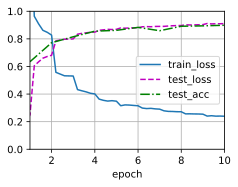

In [6]:
from utils.data.mnist import load_data_fashion_mnist
from utils.train.d2l_train import train_convolution_network

lr, num_epochs, batch_size = 0.1, 10, 128
train_loader, test_loader = load_data_fashion_mnist(batch_size, resize=96)
train_convolution_network(model, train_loader, test_loader, num_epochs, lr)